# TSP (巡回セールスマン問題)

ここでは、[[Andrew Lucas, 2013]](https://arxiv.org/abs/1302.5843) に沿って TSP をイジング模型で定式化し、シミュレーティッドアニーリングと量子アニーリングで解いてみます。

In [1]:
%matplotlib inline

import collections
import time

import matplotlib.pyplot as plt
import numpy as np

import anneal
from anneal.models import ClassicalIsingModel, QuantumIsingModel
from anneal.annealers import SimulatedAnnealer, QuantumAnnealer

まずは、距離関数と各種重みを構築する関数を定義します。

In [2]:
POSITIONS = np.array((
    (24050.0000, 123783),
    (24216.6667, 123933),
    (24233.3333, 123950),
    (24233.3333, 124016),
    (24250.0000, 123866),
    (24300.0000, 123683),
    (24316.6667, 123900),
    (24316.6667, 124083),
    (24333.3333, 123733),
    (24333.3333, 123983),
    (24333.3333, 124150),
    (24333.3333, 124200),
    (24350.0000, 123733),
    (24350.0000, 123750),
    (24350.0000, 124216),
))

In [3]:
def dist(a, b):
    a = np.array(a)
    b = np.array(b)
    return np.sqrt(((a - b)**2).sum())

def build_weights(positions, coeff=500):
    n_cities = len(positions)

    j = collections.defaultdict(int)
    max_dist = 0
    for t in range(n_cities - 2):
        for a in range(n_cities - 1):
            for b in range(n_cities - 1):
                d = dist(positions[a], positions[b])
                max_dist = d if max_dist < d else max_dist
                j[t, a, t + 1, b] = -d

    A = max_dist * coeff
    for t in range(n_cities - 1):
        for a in range(n_cities - 1):
            for b in range(n_cities - 1):
                if a != b:
                    j[t, a, t, b] -= 2*A

    for a in range(n_cities - 1):
        for t1 in range(n_cities - 1):
            for t2 in range(n_cities - 1):
                if t1 != t2:
                    j[t1, a, t2, a] -= 2*A

    h = np.zeros((n_cities - 1, n_cities - 1))
    for t in range(n_cities - 1):
        for a in range(n_cities - 1):
            h[t, a] += 2*A
            
    for a in range(n_cities - 1):
        d = dist(positions[-1], positions[a])
        h[0, a] -= d
        h[-1, a] -= d

    c = -2*A*n_cities
    return j, h, c

コールバック関数を定義

In [4]:
class Callback(object):
    def __init__(self):
        self.history = []
        
    def __call__(self, annealer, state_is_updated, model_is_updated):
        objective_value = annealer.model.objective_value()
        self.history.append(objective_value)
        if annealer.iter_count % 500 == 0:
            if isinstance(annealer.model, QuantumIsingModel):
                state = annealer.model.observe_best()
            else:
                state = annealer.model.state
            print("{}: {}'th iter, beta: {}, gamma: {}, objective_value: {}, is_valid: {}".format(
                annealer.__class__.__name__,
                annealer.iter_count,
                annealer.model.beta,
                annealer.model.__dict__.get('gamma', 0),
                objective_value,
                self.check_constraints(state)
            ))
            
    def check_constraints(self, state):
        return (
            (state.to_array().sum(axis=1) == 1).all()
            and (state.to_array().sum(axis=0) == 1).all()
        )


In [5]:
j, h, c = build_weights(POSITIONS, 1.0)

In [6]:
c_history = []
min_energy = float('inf')
best_annealer = None
iter = 0
start = time.time()
for i in range(16):
    print('{}th challenge.'.format(i))
    callback = Callback()
    c_model = ClassicalIsingModel(j, h, c, neighbor_size=1, state_shape=h.shape, beta=0.1)
    c_annealer = SimulatedAnnealer(c_model, update_limit=10, freeze_limit=2000)
    c_annealer.anneal(iter_callback=callback)
    c_history.append(callback.history)
    energy = c_model.objective_value()
    iter += c_annealer.iter_count
    if energy < min_energy:
        min_energy = energy
        best_annealer = c_annealer

best_model = best_annealer.model
print('annealing time: {}'.format(time.time() - start))
print('annealer: {}'.format(best_annealer))
print('iterations(average): {}'.format(iter/16))
print('objective: {}'.format(best_model.objective_value()))
print('state: {}'.format(best_model.state.to_array()))

0th challenge.
SimulatedAnnealer: 500'th iter, beta: 12.44820102749488, gamma: 0, objective_value: 14082.465741304533, is_valid: False
SimulatedAnnealer: 1000'th iter, beta: 1894.5640597712063, gamma: 0, objective_value: 4411.170119516368, is_valid: True
SimulatedAnnealer: 1500'th iter, beta: 288344.7149229638, gamma: 0, objective_value: 4411.170119516368, is_valid: True
SimulatedAnnealer: 2000'th iter, beta: 43884857.94143369, gamma: 0, objective_value: 4411.170119516368, is_valid: True
SimulatedAnnealer: 2500'th iter, beta: 6679091576.394419, gamma: 0, objective_value: 4411.170119516368, is_valid: True
1th challenge.
SimulatedAnnealer: 500'th iter, beta: 12.44820102749488, gamma: 0, objective_value: 10047.349730217293, is_valid: False
SimulatedAnnealer: 1000'th iter, beta: 1894.5640597712063, gamma: 0, objective_value: 3503.646612138038, is_valid: True
SimulatedAnnealer: 1500'th iter, beta: 288344.7149229638, gamma: 0, objective_value: 3503.646612138038, is_valid: True
SimulatedAnnea

In [7]:
start = time.time()
callback = Callback()
q_model = QuantumIsingModel(j, h, c, neighbor_size=1, state_shape=h.shape, beta=0.1, gamma=10, n_trotter=16)
q_annealer = QuantumAnnealer(q_model, beta_factor=0.9, update_limit=10, freeze_limit=2000)
q_annealer.anneal(iter_callback=callback)
observed = q_model.observe_best()
print('annealing time: {}'.format(time.time() - start))
print('annealer: {}'.format(q_annealer))
print('iterations: {}'.format(q_annealer.iter_count))
print('objective: {}'.format(q_model.objective_value()))
print('best state: {}'.format(observed.to_array()))
print('energy of observed: {}'.format(c_model.energy(observed)))

QuantumAnnealer: 500'th iter, beta: 8.352463828623913, gamma: 2.175813344196523, objective_value: 4701.035581137505, is_valid: False
QuantumAnnealer: 1000'th iter, beta: 17.462926957343676, gamma: 1.946899031323937, objective_value: 4001.5829667580056, is_valid: True
QuantumAnnealer: 1500'th iter, beta: 17.462926957343676, gamma: 1.946899031323937, objective_value: 4001.5829667580056, is_valid: True
QuantumAnnealer: 2000'th iter, beta: 17.462926957343676, gamma: 1.946899031323937, objective_value: 4001.5829667580056, is_valid: True
QuantumAnnealer: 2500'th iter, beta: 17.462926957343676, gamma: 1.946899031323937, objective_value: 4001.5829667580056, is_valid: True
QuantumAnnealer: 3000'th iter, beta: 17.462926957343676, gamma: 1.946899031323937, objective_value: 4001.5829667580056, is_valid: True
annealing time: 35.46546506881714
annealer: QuantumAnnealer(model=QuantumIsingModel(j=defaultdic..., h=[[  509.37..., c=-15542.20376909275, state=QUBOState(sigma=np.array((14, 14)), classical_

In [8]:
def plot_route(state, positions):
    route = np.array(
        [positions[-1]]
        + [positions[np.argmax(row)] for row in state.to_array()]
        + [positions[-1]]
    )
    plt.plot(route[:, 0], route[:, 1], '-o')

Simulated Annealing


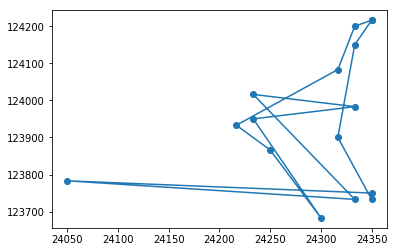

Quantum Annealing


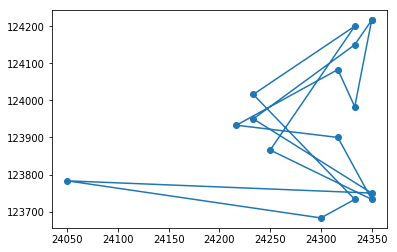

In [9]:
print('Simulated Annealing')
plot_route(best_model.state, POSITIONS)
plt.show()
print('Quantum Annealing')
plot_route(observed, POSITIONS)
plt.show()